In [18]:
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

from typing import Callable, Sequence, Optional
from dataclasses import dataclass
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from flax import linen as nn, struct
import optax
jax.devices()

env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


[cuda(id=0)]

In [ ]:
class CheckBoardDataset(eqx.Module):
    rows: int = 4
    cols: int = 4

    def get_batch(self, batch_size: int, *, key):
        key_x, key_y = jr.split(key)
        x = jr.uniform(
            key_x, (batch_size,), minval=-self.cols // 2, maxval=self.cols // 2
        )
        y = jr.uniform(
            key_y, (batch_size,), minval=-self.rows // 2, maxval=self.rows // 2
        )
        parity = jnp.floor(x) + jnp.floor(y)
        y = jnp.where(parity % 2 == 0, y, -y)
        return jnp.stack([x, y], axis=-1)

    @eqx.filter_jit
    def dataloader(self, num_batches: int, batch_size: int, *, key):
        get_batches = jax.vmap(lambda key: self.get_batch(batch_size, key=key))
        return get_batches(jr.split(key, num_batches))

In [3]:
class ResBlock(eqx.Module):
    mu: eqx.nn.Linear
    logsigma: eqx.nn.Linear
    lin1: eqx.nn.Linear
    act: Callable
    lin2: eqx.nn.Linear

    def __init__(self, dim, act=jax.nn.gelu, *, key):
        key_lin1, key_lin2, key_mu, key_sigma = jr.split(key, 4)
        self.mu = eqx.nn.Linear(dim, dim, key=key_mu)
        self.logsigma = eqx.nn.Linear(dim, dim, key=key_sigma)
        self.lin1 = eqx.nn.Linear(dim, dim, key=key_lin1)
        self.act = act
        self.lin2 = eqx.nn.Linear(dim, dim, key=key_lin2)

    def normalize(self, x, c):
        mu = x.mean(axis=-1, keepdims=True)
        sigma = x.std(axis=-1, keepdims=True)
        x = (x - mu) / sigma
        mu = self.mu(c)
        sigma = jnp.exp(self.logsigma(c))
        return x * sigma + mu

    def __call__(self, x, c, *, key=None):
        x = self.normalize(x, c)
        h = self.lin2(self.act(self.lin1(x)))
        return x + h


class CNF(eqx.Module):
    in_proj: eqx.nn.Linear
    t_proj: eqx.nn.Linear
    out_proj: eqx.nn.Linear
    blocks: Sequence[ResBlock]

    def __init__(self, dim, hidden=256, num_blocks=4, act=jax.nn.gelu, *, key):
        key_in, key_t, key_out, *keys = jr.split(key, num_blocks + 3)
        self.in_proj = eqx.nn.Linear(dim, hidden, key=key_in)
        self.t_proj = eqx.nn.Linear(1, hidden, key=key_t)
        self.out_proj = eqx.nn.Linear(hidden, dim, key=key_out)
        self.blocks = [ResBlock(hidden, act, key=key) for key in keys]

    def sample_latent(self, *, key):
        return jr.normal(key, (self.out_proj.out_features,))  # type: ignore

    def __call__(self, t, x, *, key=None):
        x = self.in_proj(x)
        c = self.t_proj(t)
        for block in self.blocks:
            x = block(x, c)
        x = self.out_proj(x)
        return x


class FlowMatching(eqx.Module):
    flow: CNF
    sigma_min: float

    def __init__(self, dim, *args, sigma_min=0.0, **kwargs):
        self.flow = CNF(dim, *args, **kwargs)
        self.sigma_min = sigma_min

    def __call__(self, t, x, args=None, *, key=None):
        return self.flow(t, x, key=key)

    def loss(self, batch, *, key):
        def sample_loss(x1, key):
            key_x0, key_t = jr.split(key)
            x0 = self.flow.sample_latent(key=key_x0)
            t = jr.uniform(key_t, (1,))
            xt = t * x1 + (1 - t) * x0 + self.sigma_min * t * x0
            target = (x1 - x0) + self.sigma_min * x0
            return optax.l2_loss(self.flow(t, xt), target)

        keys = jr.split(key, len(batch))
        losses = jax.vmap(sample_loss)(batch, keys)
        return losses.mean()

    def sample_t_logit_norm(self, *, key):
        # importance sampling using logit-normal
        logit = jr.normal(key, (1,))
        p = jax.scipy.stats.norm.pdf(logit)
        t = jax.lax.logistic(logit)
        return t, p

In [4]:
class Trainer(eqx.Module):
    epochs: int = 100
    epoch_steps: int = 128
    batch_size: int = 1024
    optimizer: optax.GradientTransformation = optax.adam(0.0001)
    filter_fn: Callable = eqx.is_inexact_array

    @eqx.filter_jit
    def train_step(self, model, opt_state, batch, *, key):
        loss_fn = lambda m: m.loss(batch, key=key)
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model)

        updates, opt_state = self.optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss

    def fit(self, model, dataset, *, key=jr.key(0)):
        opt_state = self.optimizer.init(eqx.filter(model, self.filter_fn))
        log = []
        for key in (pbar := tqdm(jr.split(key, self.epochs))):
            key, *keys = jr.split(key, self.epoch_steps + 1)
            batches = dataset.dataloader(self.epoch_steps, self.batch_size, key=key)
            for batch, key in zip(batches, keys):
                model, opt_state, loss = self.train_step(
                    model, opt_state, batch, key=key
                )
                log.append(float(loss))
            pbar.set_postfix(loss=sum(log[-self.epoch_steps:])/self.epoch_steps)
        return model, log

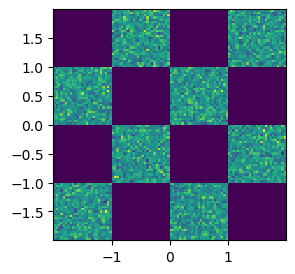

In [5]:
dataset = CheckBoardDataset()
batch = dataset.get_batch(100000, key=jr.key(0))
plt.figure(figsize=(3, 3))
plt.hist2d(*batch.T, bins=100)
plt.show()

100%|██████████| 500/500 [1:27:39<00:00, 10.52s/it, loss=0.844]


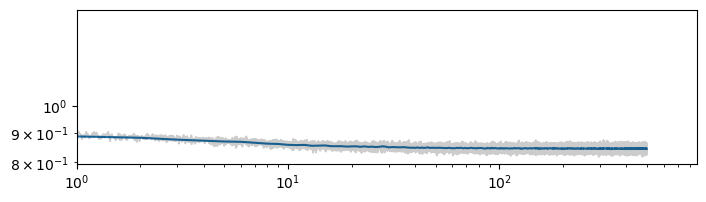

In [6]:
model = FlowMatching(dim=2, hidden=1024, num_blocks=8, key=jr.key(0))

trainer = Trainer(
    epochs=500,
    epoch_steps=100,
    batch_size=16*1024,
    optimizer=optax.adam(1e-5),
)

model, losses = trainer.fit(model, dataset)

plt.figure(figsize=(8, 2))
losses = jnp.asarray(losses).reshape(-1, trainer.epoch_steps)
plt.loglog(losses.mean(axis=-1))
x = jnp.arange(0, losses.shape[0], 1/losses.shape[1])
plt.semilogy(x, losses.flatten(), alpha=0.2, color='k')
plt.xlim(1, None)
plt.show()

In [7]:
def generate(self, n_steps=10, *, key):
    def flow_step(x, t):
        x_new = x + 1 / n_steps * self(t, x)
        return x_new, x

    x0 = self.flow.sample_latent(key=key)
    t = jnp.arange(0, 1, 1 / n_steps)[..., None]
    x1, xt = jax.lax.scan(flow_step, x0, t)
    return x1, xt

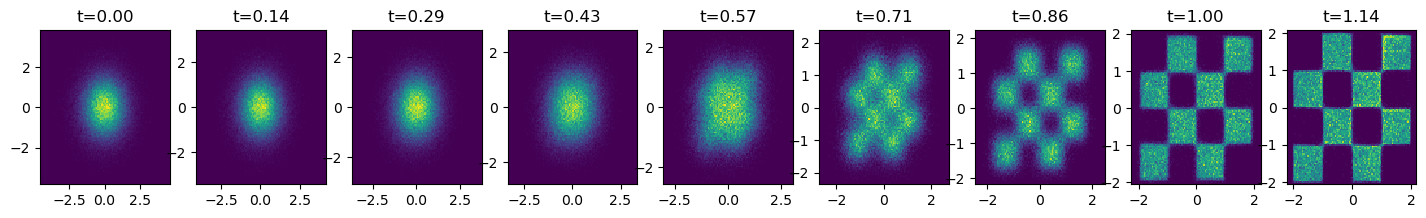

In [21]:
keys = jr.split(jr.key(42), 128*1024)
x1, xt = jax.vmap(lambda k: generate(model, 32, key=k))(keys)
xt = jnp.concatenate([xt, x1[:, jnp.newaxis]], axis=1)

plt.figure(figsize=(xt.shape[1]*2, 2))
for i, (x,y) in enumerate(zip(*xt.T)):
    i=i//4
    plt.subplot(1, xt.shape[1], i+1)
    plt.title(f"t={i/(xt.shape[1]//4-1):.2f}")
    plt.hist2d(x, y, bins=100)
plt.show()